In [1]:
import tabix
import pandas as pd
import os
import numpy as np
import sys
import tqdm.auto as tqdm

import peak_matrix_visualization as pmv
%load_ext autoreload
%autoreload 2

In [3]:
core_path = os.path.join(
    "/data/pushkare/Chromatin_modules/5.visualize_3D_interactions_and_peak_corr",
    "peak_correlations",
)
cm_path = "/data/pushkare/Chromatin_modules/1.mapped_CMs"
cm_peak_path = "/data/pushkare/Chromatin_modules/2.peaks_in_CMs/peak_files"

dataset = "test_data"

In [46]:
target_regions = pd.DataFrame(
    [
        [
            "chr22",
            23349145,
            23692745,
            "chr22_23349145_23692745_BCR",  # B cell receptor
            "crd76",
            "",
            "",
        ]
    ],
    columns=["chr_id", "start", "end", "pid", "cm_id", "rs_id", "LD_rs_ids"],
)

In [47]:
output_path = os.path.join(
    "/data/pushkare/computational_paper/06.peak_based_3D_interactions_and_correlations",
)
interaction_types = ["HiC", "MicroC"]

resolutions = [500, 1000]

In [48]:
for interaction_type in interaction_types:
    for resolution in resolutions:
        query = zip(
            target_regions["chr_id"],
            target_regions["start"],
            target_regions["end"],
            target_regions["pid"],
            target_regions["cm_id"],
            target_regions["rs_id"],
            target_regions["LD_rs_ids"],
        )
        hic_all_peaks = os.path.join(
            hic_peak_interactions_path,
            "3D_correlations",
            dataset,
            "_".join(
                [
                    dataset,
                    "peak_based_average",
                    interaction_type,
                    "interactions",
                    str(resolution) + "bp.txt",
                ]
            ),
        )
        hic_all_peaks_df = pd.read_csv(
            hic_all_peaks,
            sep="\t",
            header=None,
            names=[
                "chr_1",
                "start_1",
                "end_1",
                "pid_1",
                "chr_2",
                "start_2",
                "end_2",
                "pid_2",
                "correlation",
            ],
        )

        min_corr_per_pid, max_corr_per_pid = {}, {}
        for chromosome, region_start, region_end, pid, _, _, _ in query:
            if not "chr" in str(hic_all_peaks_df.chr_1[0]):
                hic_all_peaks_df.loc[:, "chr_1"] = (
                    "chr" + hic_all_peaks_df.chr_1.astype(str)
                )
                hic_all_peaks_df.loc[:, "chr_2"] = (
                    "chr" + hic_all_peaks_df.chr_2.astype(str)
                )
            peaks_for_corr_mtx_df = hic_all_peaks_df.loc[
                (hic_all_peaks_df.loc[:, "chr_1"] == chromosome)
                & (hic_all_peaks_df.loc[:, "chr_2"] == chromosome)
                & (hic_all_peaks_df.loc[:, "start_1"] >= region_start)
                & (hic_all_peaks_df.loc[:, "end_1"] <= region_end)
                & (hic_all_peaks_df.loc[:, "start_2"] >= region_start)
                & (hic_all_peaks_df.loc[:, "end_2"] <= region_end),
                :,
            ]
            pmv.get_corr_matrix(
                edgelist_df=peaks_for_corr_mtx_df,
                output_path=core_path,
                dataset=dataset,
                gene="_".join([pid, interaction_type, str(resolution)]),
                corr_file_name="interaction_matrix.txt",
            )

  0%|          | 0/1 [00:00<?, ?it/s]

Correlation matrix is not symmetric. Trying to fix it...


  0%|          | 0/1 [00:00<?, ?it/s]

Correlation matrix is not symmetric. Trying to fix it...


### Visualize CMs for all methods

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

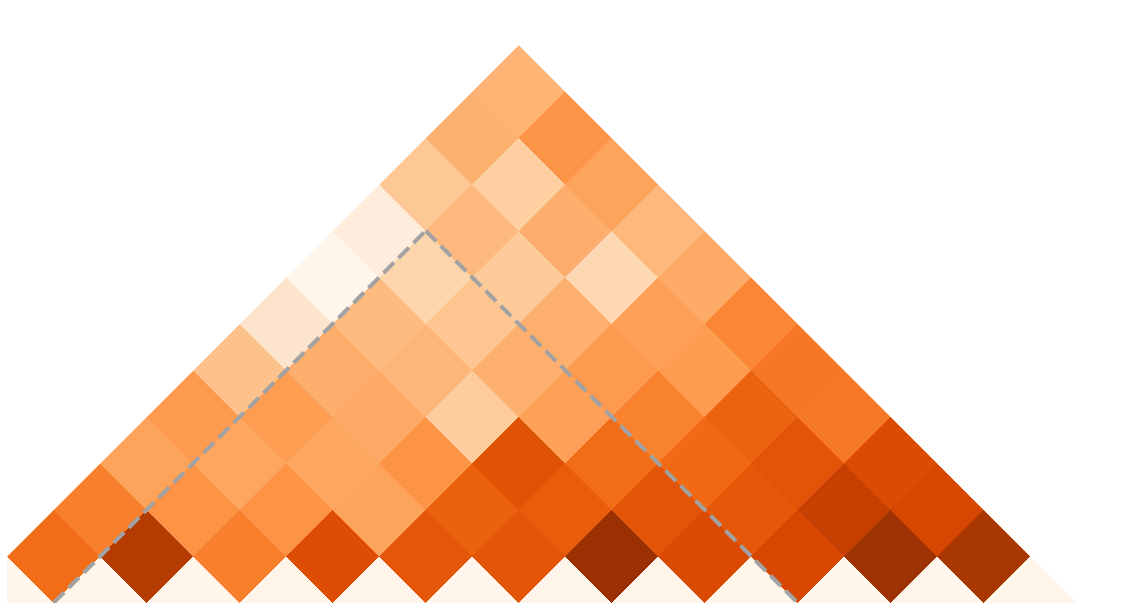

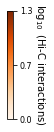

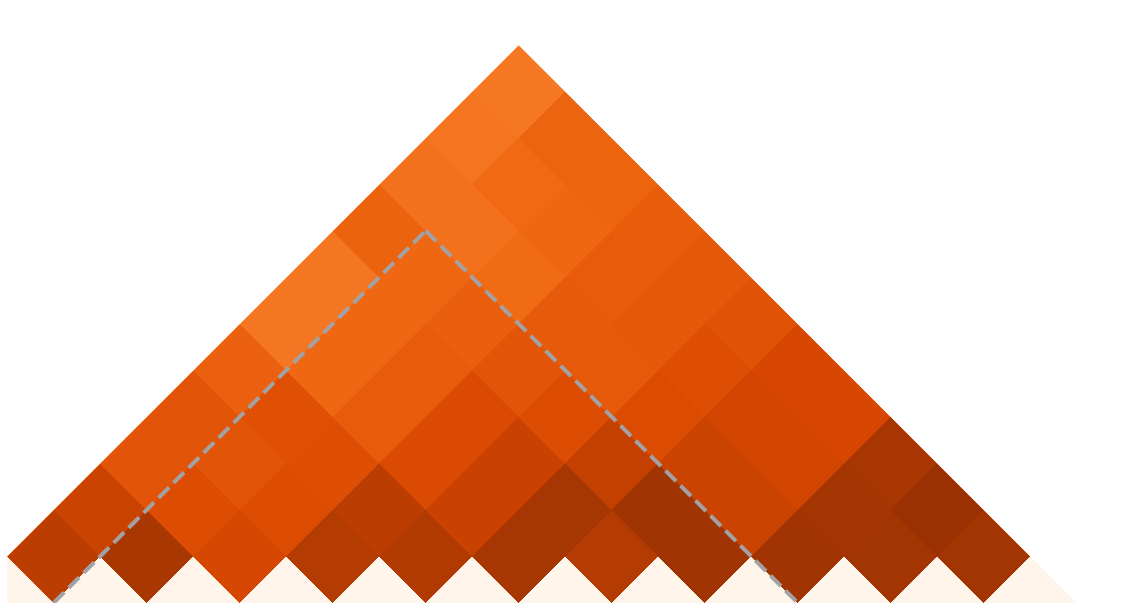

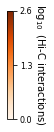

In [49]:
for interaction_type in interaction_types:
    for resolution in resolutions:
        fig_output_path = os.path.join(
            core_path, "plots", interaction_type, str(resolution) + "bp", dataset
        )
        if not os.path.exists(fig_output_path):
            os.makedirs(fig_output_path)
        query = zip(
            target_regions["chr_id"],
            target_regions["start"],
            target_regions["end"],
            target_regions["pid"],
            target_regions["cm_id"],
            target_regions["rs_id"],
            target_regions["LD_rs_ids"],
        )
        for (
            chromosome,
            region_start,
            region_end,
            pid,
            repr_crds,
            rs_ids,
            ld_rs_ids,
        ) in query:
            crds_in_region = utils.get_cms_in_region(
                core_cm_path,
                "clomics",
                dataset,
                chromosome,
                region_start,
                region_end,
                fully_in=True,
                n_peaks=n_peaks,
                bg_threshold=bg_threshold,
            )
            vcms_in_region = utils.get_cms_in_region(
                core_cm_path,
                "vcmtools",
                dataset,
                chromosome,
                region_start,
                region_end,
                fully_in=True,
                vcm_window=vcm_window,
                pv_threshold=pv_threshold,
            )
            phms_in_region = utils.get_cms_in_region(
                core_cm_path,
                "phm",
                dataset,
                chromosome,
                region_start,
                region_end,
                fully_in=True,
                pp_threshold=pp_threshold,
            )
            crd_peak_dict = get_cm_peak_dict(
                cm_peak_path, method="clomics", dataset=dataset, pp_threshold=None
            )
            vcm_peak_dict = get_cm_peak_dict(
                cm_peak_path, method="vcmtools", dataset=dataset, pp_threshold=None
            )
            phm_peak_dict = get_cm_peak_dict(
                cm_peak_path,
                method="phm",
                dataset=dataset,
                pp_threshold=pp_threshold,
            )

            corr_df_for_viz = pmv.prepare_data_for_hic_heatmap(
                input_path=core_path,
                dataset=dataset,
                gene="_".join([pid, interaction_type, str(resolution)]),
                corr_file_name="interaction_matrix.txt",
            )
            crd_coordinates = pmv.get_cm_coordinates(
                corr_or_hic_peak_df=corr_df_for_viz,
                cm_dict=crd_peak_dict,
                cms_to_plot=crds_in_region,
                data_type="hic",
            )
            vcm_coordinates = pmv.get_cm_coordinates(
                corr_or_hic_peak_df=corr_df_for_viz,
                cm_dict=vcm_peak_dict,
                cms_to_plot=vcms_in_region,
                data_type="hic",
            )
            phm_coordinates = pmv.get_cm_coordinates(
                corr_or_hic_peak_df=corr_df_for_viz,
                cm_dict=phm_peak_dict,
                cms_to_plot=phms_in_region,
                data_type="hic",
            )
            if interaction_type == "HiC":
                interaction_name = "Hi-C"
            elif interaction_type == "MicroC":
                interaction_name = "Micro-C"
            pmv.plot_hic_peak_heatmap(
                resolution,
                dataset,
                hic_data=corr_df_for_viz,
                line_width=4,
                ylim_fraction=0.6,
                vmax_norm=corr_df_for_viz.max().max()
                + 0.1 * corr_df_for_viz.max().max(),
                save_fig=True,
                crd_coordinates=crd_coordinates,
                vcm_coordinates=vcm_coordinates,
                phm_coordinates=phm_coordinates,
                cbar_label="$\\log_{10}$ (" + interaction_name + " interactions)",
                suffix="_".join(
                    [
                        pid,
                        interaction_type,
                        str(resolution),
                        "vcmtools",
                        "clomics",
                        "phm",
                        "CMs",
                    ]
                ),
                output_path=fig_output_path,
            )

### Visualize the most variable CMs

In [12]:
# for dataset in tqdm.tqdm(['FIB']): # dataset
#     fig_output_path = os.path.join(
#         core_path,
#         'plots',
#         dataset,
#         'most_variable_cms'
#     )
#     if not os.path.exists(fig_output_path):
#         os.makedirs(fig_output_path)

#     interesting_cms = [
#         el
#         for sublist in target_regions[dataset + '_crd_id'].str.split(',').to_list()
#         for el in sublist
#     ]
#     aCM_scores_df = pd.read_csv(
#         os.path.join(
#             aCM_scores_path,
#             marks,
#             method_name,
#             dataset,
#             'aCM_matrix',
#             'aCM_matrix.bed'
#         ),
#         sep='\t',
#         index_col=0
#     )
#     most_variable_cms = aCM_scores_df.loc[interesting_cms, :].std(axis=1).to_frame()
#     # select top 10 most variable CMs
#     top_most_variable_cms = list(most_variable_cms.sort_values(0, ascending=False).iloc[:10, :].index)
#     most_variable_cm_pids = set(
#         pd.concat(
#             [
#                 target_regions[target_regions[dataset + '_crd_id'].str.contains(variable_cm)]
#                 for variable_cm in top_most_variable_cms
#             ]
#         ).loc[:, 'pid']
#     )

#     query = zip(
#         target_regions['chr_id'],
#         target_regions['start'],
#         target_regions['end'],
#         target_regions['pid'],
#         target_regions[dataset + '_crd_id'],
#         target_regions[dataset + '_rs_id'],
#         target_regions[dataset + '_LD_rs_ids'],
#     )

#     for chromosome, region_start, region_end, pid, repr_crds, rs_ids, ld_rs_ids in query:
#         if not pid in most_variable_cm_pids:
#             continue
#         cms_in_region = get_cms_in_region(
#             method,
#             marks,
#             dataset,
#             chromosome,
#             region_start,
#             region_end,
#             pp_threshold=None
#         )
#         cm_peak_dict = get_cm_peak_dict(cm_peak_path, marks, method, dataset)
#         corr_df_for_viz = pmv.prepare_data_for_hic_heatmap(
#             input_path=core_path,
#             dataset=dataset,
#             gene=pid,
#             corr_file_name='correlation_matrix.txt'
#         )
#         cm_coordinates = pmv.get_cm_coordinates(
#             corr_or_hic_peak_df=corr_df_for_viz,
#             cm_dict=cm_peak_dict,
#             cms_to_plot=cms_in_region
#         )
# #         repr_cm_coordinates = pmv.get_cm_coordinates(
# #             corr_or_hic_peak_df=corr_df_for_viz,
# #             cm_dict=cm_peak_dict,
# #             cms_to_plot=repr_crds.split(',')
# #         )
#         pmv.plot_peak_corr_heatmap(
#             dataset,
#             corr_data=corr_df_for_viz,
#             vmin_norm=min_max_per_pid[pid]['min_corr'],
#             vmax_norm=min_max_per_pid[pid]['max_corr'],
#             save_fig=True,
#             crd_coordinates=cm_coordinates,
#             vcm_coordinates=None,
#             phm_coordinates=None,
# #             cms_to_highlight=repr_cm_coordinates,
#             suffix=pid,
#             format_='tiff',
#             output_path=fig_output_path
#         )

### Extract the most reproducible CMs across three methods with the most variable CM activity score

In [44]:
# repr_cms_dfs_dict = {}
# queries_dict = {}
# min_corr_dict_per_ds = {}
# max_corr_dict_per_ds = {}
# for dataset in tqdm.tqdm(datasets):
#     repr_cms_df = pd.read_csv(
#         os.path.join(
#             reproduc_path,
#             marks,
#             '_'.join([dataset, 'most_variable_reproducible', method + '.tracks.bed'])
#         ),
#         sep='\t',
#         header=None,
#         usecols=[0, 1, 2, 3]
#     )
#     repr_cms_df.columns = ['chr', 'start', 'end', 'cm_id']
#     repr_cms_df.loc[:, 'cm_length'] = repr_cms_df.loc[:, 'end'] - repr_cms_df.loc[:, 'start']
#     repr_cms_df.loc[:, 'region_end'] = repr_cms_df.loc[:, 'end'] + (repr_cms_df.loc[:, 'cm_length'] * 5).astype(int)
#     repr_cms_df.loc[:, 'region_start'] = repr_cms_df.loc[:, 'start'] - (repr_cms_df.loc[:, 'cm_length'] * 5).astype(int)
#     repr_cms_df.loc[:, 'region_start'] = repr_cms_df.loc[:, 'region_start'].apply(lambda x : x if x > 0 else 1).copy()
#     if not 'chr' in str(repr_cms_df.loc[0, 'chr']):
#         repr_cms_df.loc[:, 'chr'] = 'chr' + repr_cms_df.loc[:, 'chr'].astype(str)
#     repr_cms_df.loc[:, 'pid'] = repr_cms_df.loc[:, 'chr'] + '_' + \
#         repr_cms_df.loc[:, 'region_start'].astype(str) + '_' + \
#         repr_cms_df.loc[:, 'region_end'].astype(str)

#     repr_cms_dfs_dict[dataset] = repr_cms_df

#     query = list(zip(
#         repr_cms_df['chr'],
#         repr_cms_df['region_start'],
#         repr_cms_df['region_end'],
#         repr_cms_df['pid'],
#         repr_cms_df['cm_id']
#     ))
#     queries_dict[dataset] = query
#     corr_tabix = tabix.open(
#         os.path.join(
#             core_path,
#             'bed_tbi_corr',
#             dataset + '_all_marks_theoretical_corr_with_p_values_sorted.bed.gz'
#         )
#     )
#     min_corr_per_pid, max_corr_per_pid = {}, {}
#     for chromosome, region_start, region_end, pid, repr_crds in query:
#         peak_corr = corr_tabix.query(chromosome, region_start, region_end)
#         peaks_for_corr_mtx = [
#             [
#                 peak_pair_info[0], int(peak_pair_info[1]), int(peak_pair_info[2]), peak_pair_info[3],
#                 peak_pair_info[4], int(peak_pair_info[5]), int(peak_pair_info[6]), peak_pair_info[7],
#                 float(peak_pair_info[-1]),
#             ]
#             for peak_pair_info in peak_corr
#             if (int(peak_pair_info[5]) >= region_start) and (int(peak_pair_info[6]) <= region_end)
#         ]
#         peaks_for_corr_mtx_df = pd.DataFrame(
#             peaks_for_corr_mtx,
#             columns = [
#                 'chr_1', 'start_1', 'end_1', 'pid_1',
#                 'chr_2', 'start_2', 'end_2', 'pid_2',
#                 'correlation'
#             ]
#         )
#         pmv.get_corr_matrix(
#             edgelist_df=peaks_for_corr_mtx_df,
#             output_path=core_path,
#             dataset=dataset,
#             gene=pid,
#             corr_file_name='correlation_matrix.txt'
#         )
#         corr_df_for_viz = pmv.prepare_data_for_corr_heatmap(
#             input_path=core_path,
#             dataset=dataset,
#             gene=pid,
#             corr_file_name='correlation_matrix.txt'
#         )

#         min_corr_per_pid[pid] = corr_df_for_viz.min().min()
#         max_corr_per_pid[pid] = corr_df_for_viz.max().max()
#     min_corr_dict_per_ds[dataset] = min_corr_per_pid
#     max_corr_dict_per_ds[dataset] = max_corr_per_pid

  0%|          | 0/2 [00:00<?, ?it/s]

Correlation matrix is not symmetric. Trying to fix it...
Correlation matrix is not symmetric. Trying to fix it...
Correlation matrix is not symmetric. Trying to fix it...
Correlation matrix is not symmetric. Trying to fix it...
Correlation matrix is not symmetric. Trying to fix it...
Correlation matrix is not symmetric. Trying to fix it...
Correlation matrix is not symmetric. Trying to fix it...
Correlation matrix is not symmetric. Trying to fix it...
Correlation matrix is not symmetric. Trying to fix it...
Correlation matrix is not symmetric. Trying to fix it...
Correlation matrix is not symmetric. Trying to fix it...
Correlation matrix is not symmetric. Trying to fix it...


In [ ]:
single_g_dict = {
    'REL': [[61_108_709, 61_158_747], [60_717_408, 61_550_047], 'chr2', 'crd2167', 'rs1432296', 61068167],
    'PAX8': [[113_973_574, 114_036_498], [113_745_332, 114_264_739], 'chr2', 'crd2512', 'rs6755639', 113981810],
    'GATA3': [[8_096_651, 8_117_161], [7_386_522, 8_827_289], 'chr10', 'crd10646', 'rs142819107', 8091065],
    'MEF2A': [[100_105_622, 100_256_693], [99_875_011, 100_487_303], 'chr15', 'crd15091', 'rs11853151', 100050437]}
    'AXIN2': [[63_524_681, 63_557_766], [63_000_000, 64_000_000], 'chr17', '', 'rs143348853', 63560292], n

  0%|          | 0/1 [00:00<?, ?it/s]

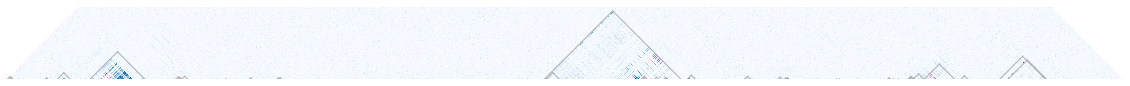

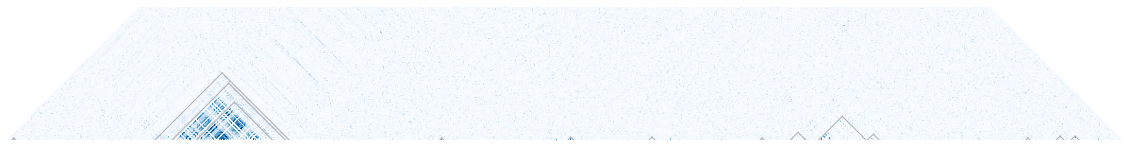

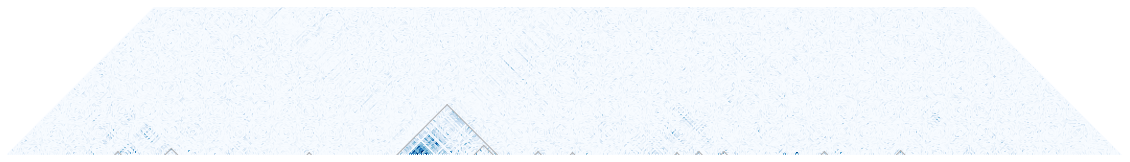

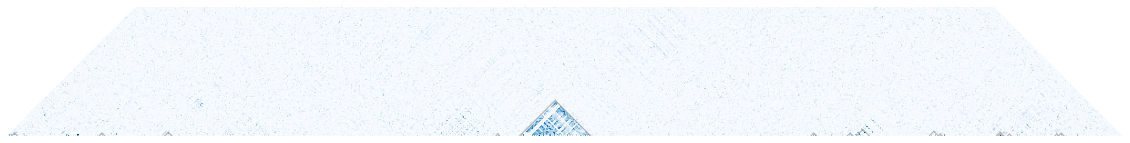

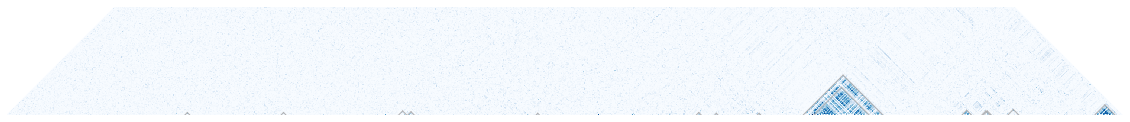

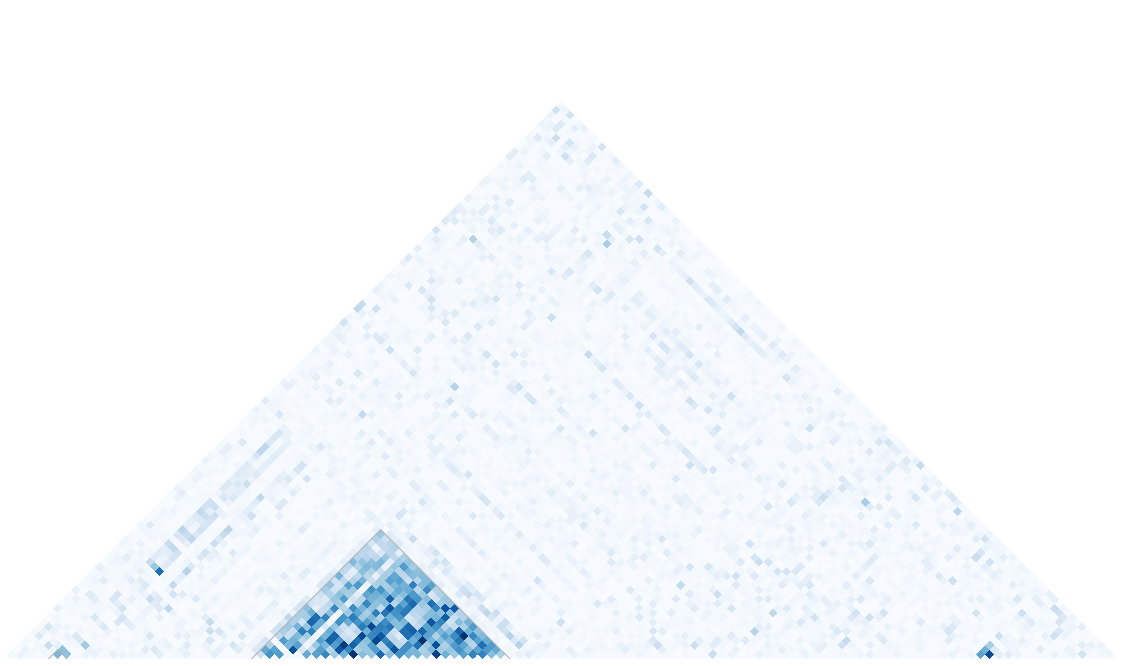

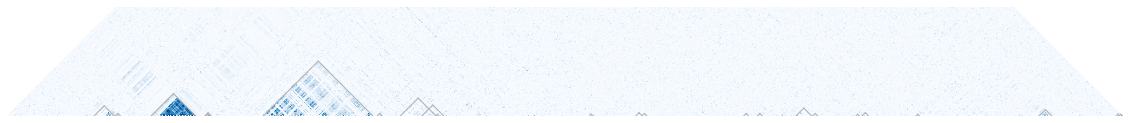

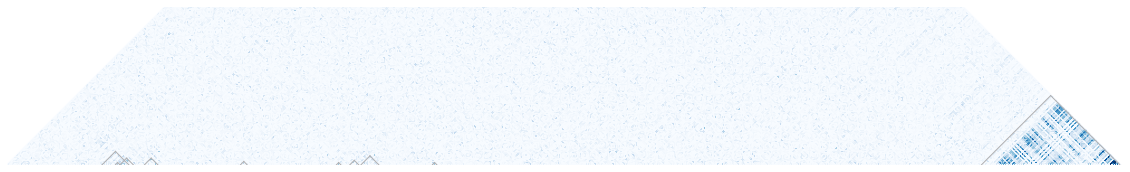

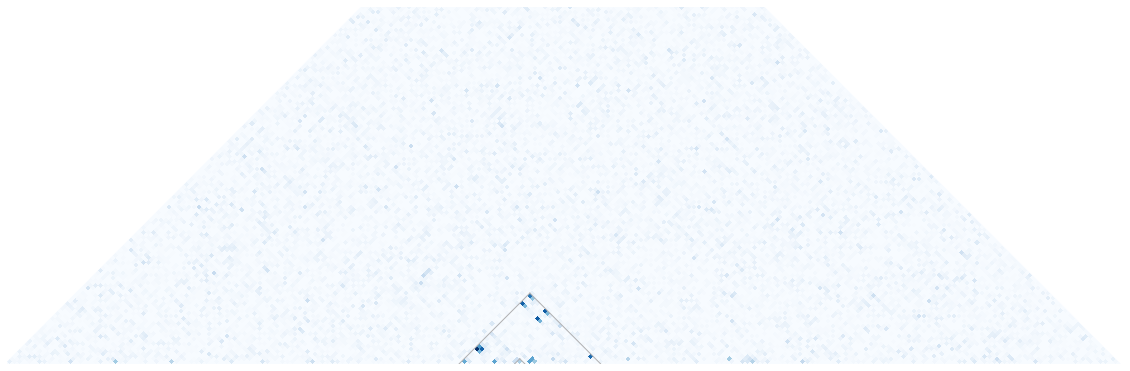

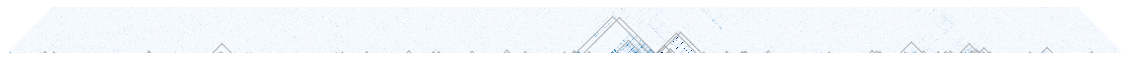

In [45]:
for dataset in tqdm.tqdm(["FIB"]):
    fig_output_path = os.path.join(
        core_path,
        "plots",
        dataset,
        "most_reproducible_between_methods_and_variable_cms",
    )
    if not os.path.exists(fig_output_path):
        os.makedirs(fig_output_path)

    for chromosome, region_start, region_end, pid, repr_crds in queries_dict[dataset]:
        cms_in_region = get_cms_in_region(
            method,
            marks,
            dataset,
            chromosome,
            region_start,
            region_end,
            pp_threshold=None,
        )
        cm_peak_dict = get_cm_peak_dict(cm_peak_path, marks, method, dataset)
        corr_df_for_viz = pmv.prepare_data_for_corr_heatmap(
            input_path=core_path,
            dataset=dataset,
            gene=pid,
            corr_file_name="correlation_matrix.txt",
        )
        cm_coordinates = pmv.get_cm_coordinates(
            corr_or_hic_peak_df=corr_df_for_viz,
            cm_dict=cm_peak_dict,
            cms_to_plot=cms_in_region,
        )
        #         repr_cm_coordinates = pmv.get_cm_coordinates(
        #             corr_or_hic_peak_df=corr_df_for_viz,
        #             cm_dict=cm_peak_dict,
        #             cms_to_plot=repr_crds.split(',')
        #         )
        pmv.plot_peak_corr_heatmap(
            dataset,
            corr_data=corr_df_for_viz,
            vmin_norm=min_corr_dict_per_ds[dataset][pid],
            vmax_norm=max_corr_dict_per_ds[dataset][pid],
            save_fig=True,
            crd_coordinates=cm_coordinates,
            vcm_coordinates=None,
            phm_coordinates=None,
            #             cms_to_highlight=repr_cm_coordinates,
            suffix=pid,
            format_="tiff",
            output_path=fig_output_path,
        )